# 2.7.4 The Insulin Minimal Model

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

## The Insulin Model

In previous notebooks, we've studied and implemented the glucose minimal model.  Now we'll implement the other half of the Minimal Model.  In the glucose minimal model, we created a function $I(t)$ from data, and used that as input as we attempted to model glucose levels $G$ and tissue insulin $X$.  Here, however, we use experimental data to create the input $G(t)$, and attempt to model the total insulin levels $I$.   

<br>

Notice that the insulin model builds a relationship only between $G$ and $I$, rather than amongst $G$, $I$, and $X$.  Because we are assuming a level of $G$ defined by experimental data $G(t)$, we don't need to worry about how much the insulin is reducing glucose (and thus how much is in the blood vs.  the tissue fluid).  Here we are only interested in how glucose in the blood stream prods the body to change insulin production.

<br>

The code hidden in the next cell imports the glucose and insulin data as the DataFrame `data` with columns called `glucose` and `insulin`.

In [5]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap06.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap06 import *
import pandas as pd
import numpy as np

filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/glucose_insulin.csv'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder.  Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/glucose_insulin.csv'
data = pd.read_csv(filename, index_col='time')

### Part I (Investigation)

The simplified system that we are modeling leads to a simplified system.  In the insulin minimal model, the concentration of insulin, $I(t)$, is governed by a single differential equatino:

<br>

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

<br>

where $G(t)$ is the concentration of glucose at time $t$, and 
$k$, $\gamma$, and $G_T$ are positive-valued parameters.  $G_T$ is the glucose threshold, which plays a role similar to $G_B$ in the glucose model.


✅ A. Explain the first term of the right hand side in terms of its effect on the differential equation.

✅ ✅  Answer A here

<br>

✅ B. Given its effect on the equation, what do you think the first term represents in the physical system?

✅ ✅  Answer B here

<br>

✅ C. Explain the second term of the right hand side in terms of its effect on the differential equation.  What does the fact that $t$ appears in the equation mean? (It might help to think of the coeffienct as $\gamma t$.)

✅ ✅  Answer C here

<br>

✅ D. What does this term represent in the physical system?  

✅ ✅  Answer D here

### Part 2 (The System)

Write a version of `make_system` that takes the parameters of the model (`I0`, `k`, `gamma`, and `G_T`) as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_solve_ivp`.  Then use it to make a `System` object with the parameters listed below.

<br>

Consider what has changed from the glucose model.  Before we used measured data about the insulin levels (`data.insulin`) to define `I` in slope function.  Here, we want to use measured values of glucose to use in the slope function.

<br>

A hint: as you implement this model, recognize that we will be following the same path that we followed in the "Glucose Minimal" notebooks.  In other words, you have a structure in place, so use cut-and-paste liberally.   For each part of the implementation, you'll need to think about what has changed, and adapt your code to those changes.  For simplicity's sake, hard code `dt = 1` in the system made by `make_system`.

In [23]:
# Here are our initial parameters
I0 = 360   
k = 0.25
gamma = 0.005
G_T = 80

# Pack the parameters into a 'params' tuple
params = I0, k, gamma, G_T

In [28]:
# Define make_system
# The system should hold an object called 'init' and another object called 'params'
# It should also include a function 'G' that incorporates the glucose data
def make_system(params, data):
    I0, k, gamma, G_T = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    G = interp1d(data.glucose.index,data.glucose.values)
    
    init = pd.Series(dict(I=I0))
    
    return dict(init=init, params=params,
                  G=G,
                  t_0=t_0, t_end=t_end, dt=1)


In [29]:
# Create a system
system = make_system(params,data)

###  Part 3 (Slope Function)

Write a slope function that takes a time stamp, a `State` object, and a `System` object, and returns the derivative of `I` with respect to time.  Test your function with the initial conditions from `system`.

<br>

In this step, you are discretizing the differential equation--that is, you are finding the slope of the curve by evaluating the variable values at a discrete time step.

In [11]:
# Define the slope_function

def slope_func(t, state, system):
    I = state
    I0, k, gamma, G_T = system['params'] 
    G = system['G']
        
    dIdt = -k*I + gamma*(G(t) - G_T)*t
    
    return dIdt

In [30]:
# Test the function with your initial values
# The initial result should be -90
dIdt = slope_func(0,system['init'],system)
dIdt

I   -90.0
dtype: float64

### Part 4 (Running and Plotting)

Run `run_solve_ivp` with your `System` object and slope function, and plot the results, along with the measured insulin levels.  Use the keyword argument `t_eval=data.index` so the results are evaluated as the same time stamps as the data.

<br>

`run_solve_ivp` takes takes the slope that is calculated by `slope_func`, and creates a curve out of it.  For each step, it finds the slope, and goes up or down at that rate until the next evaluation point.  

<br>

It would be like if someone gave you directions while you were blind-folded: "go 10 feet at an angle 30 degrees to the left... now go 15 feet at an angle 10 degrees to the right... etc..."   The path that you followed would be the function curve created by `run_solve_ivp`.  In doing so, it approximates a curve that solves the differential equation discretized by `slope_func`.

In [32]:
# Call run_solve_ivp; check to make sure that "details.success" is true
results, details = run_solve_ivp(system, slope_func,
                                  t_eval=data.index)
details.success

True

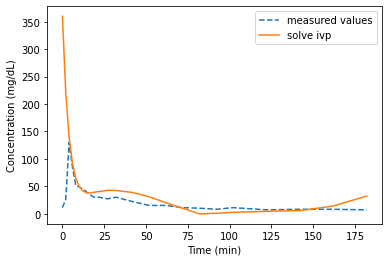

In [33]:
# Plot the results along with measured insulin
# The measured insulin values are contained in the DataFrame 'data'
# under the name 'insulin'
data.insulin.plot(style='--', label='measured values',
                 legend=True)
results.I.plot(style='-', label='solve ivp',color='C1',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);

✅ Why is the error so large for our model in the first few minutes?  Why is it OK to ignore this error?

✅ ✅  Answer here.

### Part 5 (The Error Function)

Write an error function that takes `params` as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, call `run_solve_ivp`, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the given parameters.

<br>

Hint: As we did with the glucose model, you might want to drop the first 2-3 elements from the sequence of errors.

In [36]:
# Write the error function

def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return errors.iloc[2:]

In [37]:
# Test the function
error_func(params,data)

4       9.034460
6       6.817834
8      13.878078
10      0.796775
12     -3.124428
14     -2.469379
16      2.620296
19      9.005274
22     10.347986
27     15.518216
32     12.247380
42     16.665571
52     15.748047
62      4.745901
72     -1.258665
82    -10.445431
92     -7.238726
102    -8.574571
122    -2.730228
142    -2.466766
162     5.991114
182    25.135250
dtype: float64

### Part 6 (The Least Squares Method)

Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

<br>

`leastsq` solves an optimization problem: it tries to minimize the difference between the curve created by the measured data and the curve created by the simulation.  In doing so, it defines the best parameters to make the model match the real world data.

In [41]:
# Use leastsq to find the best_params
best_params,fit_details = leastsq(error_func,params,data)
best_params

array([3.11971760e+02, 2.30800995e-01, 3.17960711e-03, 7.92196814e+01])

In [42]:
# Redefine params as best_params and rerun simulation
# Give the results a different name (e.g. results_best)
# than the name you gave the original results you found
# in part 4
system = make_system(best_params, data)

results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=data.index)

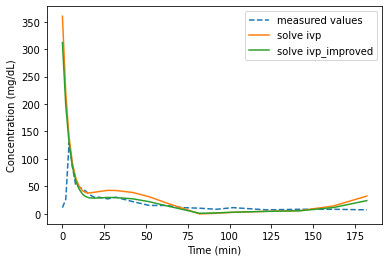

In [43]:
# Plot the results of both simulations along with measured insulin data
data.insulin.plot(style='--', label='measured values',
                  legend=True)
results.I.plot(style='-', label='solve ivp',color='C1',
               legend=True)
results2.I.plot(style='-', label='solve ivp_improved',color='C2',
                xlabel='Time (min)',
                ylabel='Concentration (mg/dL)',
               legend=True);

### Part 7 (Analysis)

This section is set up to allow you to make changes to parameters and to see the results quickly.   Answer the questions below by "playing" with the model.

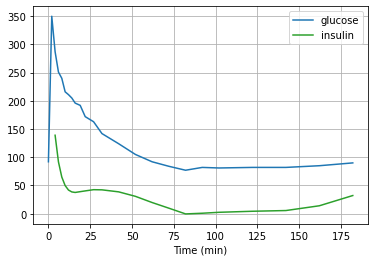

In [70]:
# Replace the values for I0, k, gamma, and G_T with 
# the best_params you found in part 6
I0 = 360   
k = 0.25
gamma = 0.005
G_T = 80
params = I0, k, gamma, G_T
system = make_system(params,data)
results7, details = run_solve_ivp(system,slope_func,t_eval=data.index)
results7 = results7.iloc[2:]



data.glucose.plot(label='glucose',legend=True)
results7.I.plot(style='-', label='insulin',color='C2',
                xlabel='Time (min)',grid=True,
               legend=True);

✅ A. This model attempts to predict how the body will react to glucose levels by producing insulin.  Put this relationship between glucose and insulin levels in your own words.  What *happens* in this plot?

✅ ✅  Answer A here

<br>

✅ B. Which term in the differential equation "dominates" the behavior of the insulin levels?  To test, set k=0 and run, and then set gamma = 0, and do the same.

✅ ✅  Answer B here

<br>

✅ C. Given your observations in the previous question, try to explain why the insulin levels suddenly start to change after $t\approx 160$.  How does the answer to A depend on which "region" of the plot you are looking at?

✅ ✅  Answer C here

<br>

✅ What happens to insulin levels between $t=15$ and $t=50$?  How are the two terms in the equation interacting here?

✅ ✅  Answer D here

